In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('GOOG.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [3]:
fatures = df.drop(['symbol', 'date', 'adjClose'], axis=1).values
labels = df['adjClose'].values.reshape(-1, 1)

In [4]:
feature_scale = StandardScaler()
features = feature_scale.fit_transform(fatures)
label_scale = StandardScaler()
labels = label_scale.fit_transform(labels)

In [5]:
def create_seq(features, labels, seq_length = 30):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_seq(fatures, labels)    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [47]:
class RNNModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if model_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid model type. Choose from 'rnn', 'lstm', or 'gru'.")
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out    

In [48]:
def training(model, X_train, y_train, X_test, y_test, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            model.eval()
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')    
    return model           

In [49]:
print(X_train.shape)
print(y_train.shape)


torch.Size([982, 30, 11])
torch.Size([982, 1])


In [50]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

In [51]:
rnn_model = RNNModel(
    model_type='rnn', 
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
)
lstm_model = RNNModel(
    model_type='lstm', 
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
)
gru_model = RNNModel(
    model_type='gru', 
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
)

In [52]:
rnn_train = training(
    model=rnn_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    num_epochs=100,
    learning_rate=0.001
)

Epoch [10/100], Loss: 1.0088, Test Loss: 1.0018
Epoch [20/100], Loss: 0.9902, Test Loss: 0.9794
Epoch [30/100], Loss: 0.9820, Test Loss: 0.9757
Epoch [40/100], Loss: 0.9830, Test Loss: 0.9754
Epoch [50/100], Loss: 0.9824, Test Loss: 0.9753
Epoch [60/100], Loss: 0.9820, Test Loss: 0.9752
Epoch [70/100], Loss: 0.9821, Test Loss: 0.9748
Epoch [80/100], Loss: 0.9820, Test Loss: 0.9748
Epoch [90/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [100/100], Loss: 0.9820, Test Loss: 0.9749


In [53]:
lstm_train = training(
    model=lstm_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    num_epochs=100,
    learning_rate=0.001
)

Epoch [10/100], Loss: 0.9825, Test Loss: 0.9754
Epoch [20/100], Loss: 0.9820, Test Loss: 0.9752
Epoch [30/100], Loss: 0.9821, Test Loss: 0.9748
Epoch [40/100], Loss: 0.9820, Test Loss: 0.9748
Epoch [50/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [60/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [70/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [80/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [90/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [100/100], Loss: 0.9820, Test Loss: 0.9749


In [54]:
gru_train = training(
    model=gru_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    num_epochs=100,
    learning_rate=0.001
)

Epoch [10/100], Loss: 0.9830, Test Loss: 0.9751
Epoch [20/100], Loss: 0.9824, Test Loss: 0.9782
Epoch [30/100], Loss: 0.9828, Test Loss: 0.9757
Epoch [40/100], Loss: 0.9828, Test Loss: 0.9766
Epoch [50/100], Loss: 0.9825, Test Loss: 0.9748
Epoch [60/100], Loss: 0.9821, Test Loss: 0.9750
Epoch [70/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [80/100], Loss: 0.9820, Test Loss: 0.9748
Epoch [90/100], Loss: 0.9820, Test Loss: 0.9749
Epoch [100/100], Loss: 0.9820, Test Loss: 0.9749


In [62]:
print(rnn_model.eval())
print('\n')
print(lstm_model.eval())
print('\n')
print(gru_model.eval())


RNNModel(
  (rnn): RNN(11, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


RNNModel(
  (rnn): LSTM(11, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


RNNModel(
  (rnn): GRU(11, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [66]:
with torch.no_grad():
    x_rnn = X_test[:1]
    out_rnn, h_rnn = rnn_model.rnn(x_rnn)
    print(out_rnn.shape)

with torch.no_grad():
    x_lstm = X_test[:1]
    out_lstm, h_lstm = lstm_model.rnn(x_lstm)
    print(out_lstm.shape)

with torch.no_grad():
    x_gru = X_test[:1]
    out_gru, h_gru = gru_model.rnn(x_gru)
    print(out_gru.shape)    

torch.Size([1, 30, 64])
torch.Size([1, 30, 64])
torch.Size([1, 30, 64])


In [67]:
hidden_state_rnn = out_rnn.squeeze(0).numpy()
hidden_state_lstm = out_lstm.squeeze(0).numpy()
hidden_state_gru = out_gru.squeeze(0).numpy()

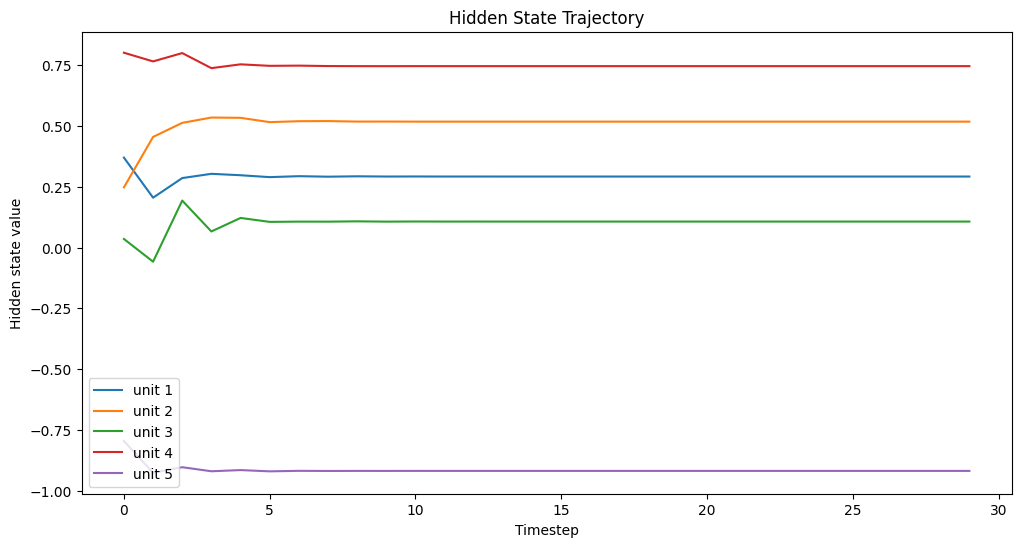

In [ ]:
plt.figure(figsize=(12,6))
for i in range(min(5, hidden_state_rnn.shape[1])): 
    plt.plot(hidden_state_rnn[:, i], label=f'unit {i+1}')

plt.xlabel("Timestep")
plt.ylabel("Hidden state value")
plt.title("Hidden State Trajectory for RNN")
plt.legend()
plt.show()

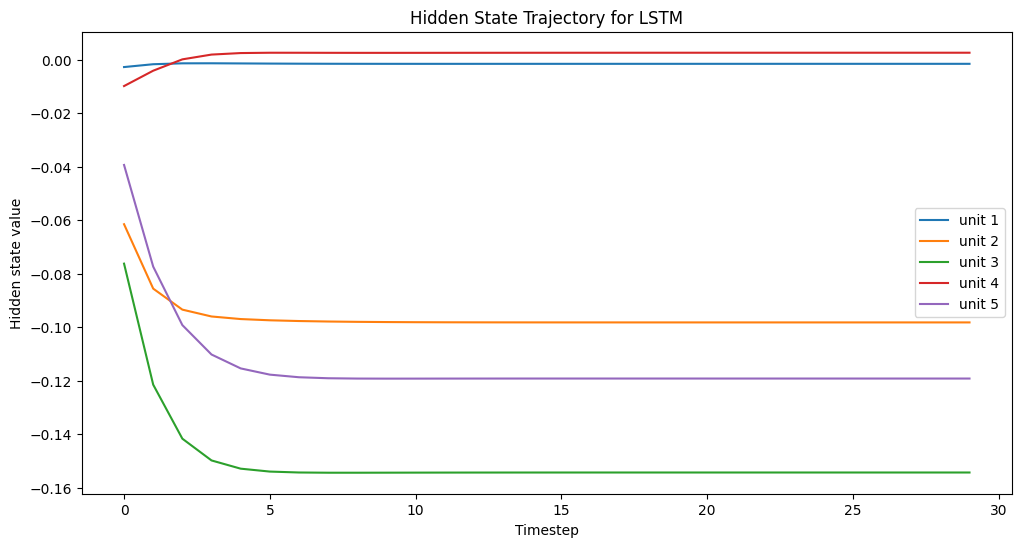

In [74]:
plt.figure(figsize=(12,6))
for i in range(min(5, hidden_state_lstm.shape[1])): 
    plt.plot(hidden_state_lstm[:, i], label=f'unit {i+1}')

plt.xlabel("Timestep")
plt.ylabel("Hidden state value")
plt.title("Hidden State Trajectory for LSTM")
plt.legend()
plt.show()

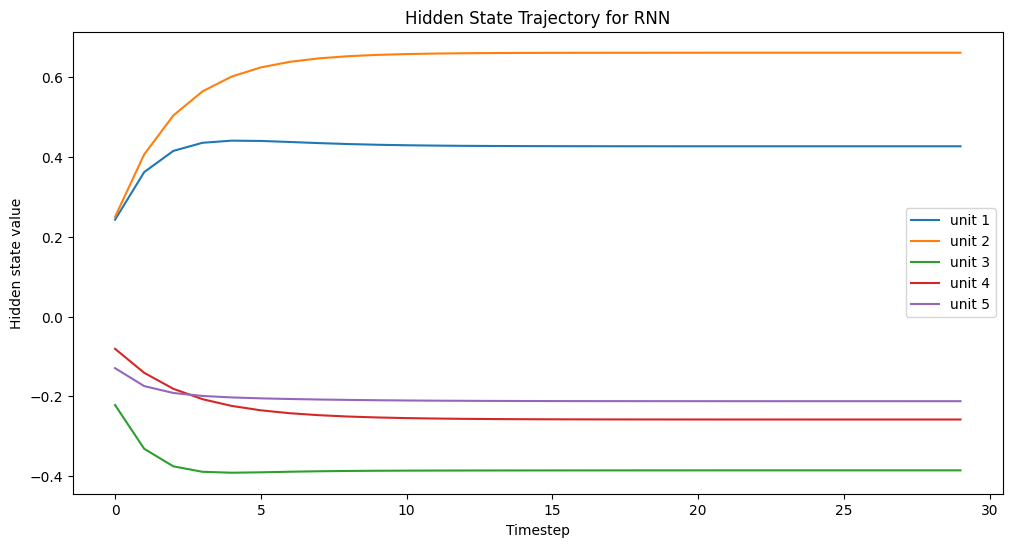

In [75]:
plt.figure(figsize=(12,6))
for i in range(min(5, hidden_state_gru.shape[1])): 
    plt.plot(hidden_state_gru[:, i], label=f'unit {i+1}')

plt.xlabel("Timestep")
plt.ylabel("Hidden state value")
plt.title("Hidden State Trajectory for RNN")
plt.legend()
plt.show()

In [76]:
def plot_hidden_states(model, X_sample):
    model.eval()
    with torch.no_grad():
        out, _ = model.rnn(X_sample)
        hs = out.squeeze(0).numpy()
    
    plt.figure(figsize=(12,6))
    plt.imshow(hs.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel("Timestep")
    plt.ylabel("Hidden unit")
    plt.title(f"Hidden State Heatmap ({model.model_type.upper()})")
    plt.show()

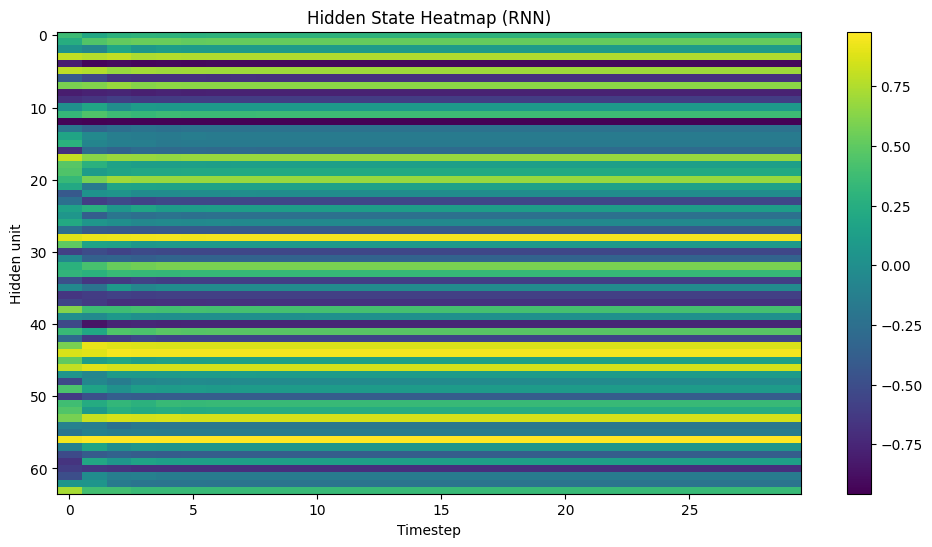

In [78]:
plot_hidden_states(rnn_model, X_test[:1])

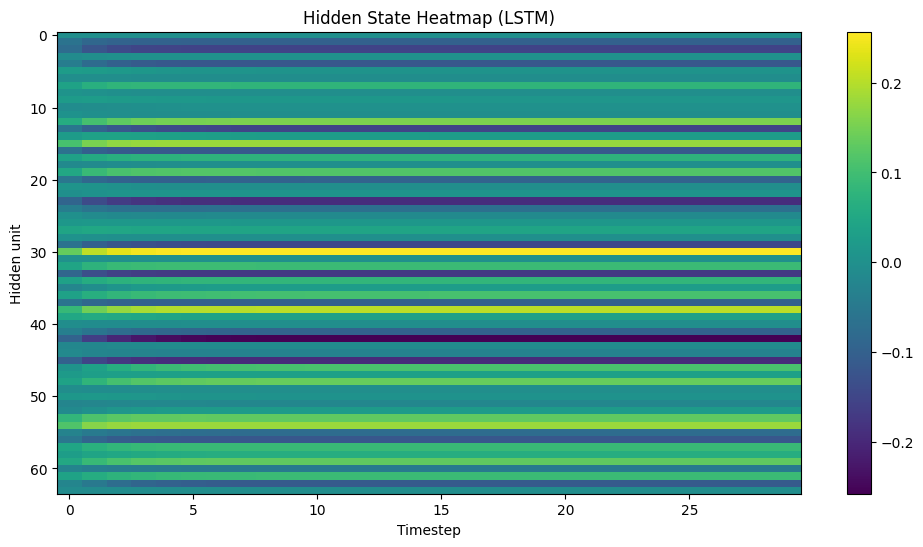

In [80]:
plot_hidden_states(lstm_model, X_test[:1])

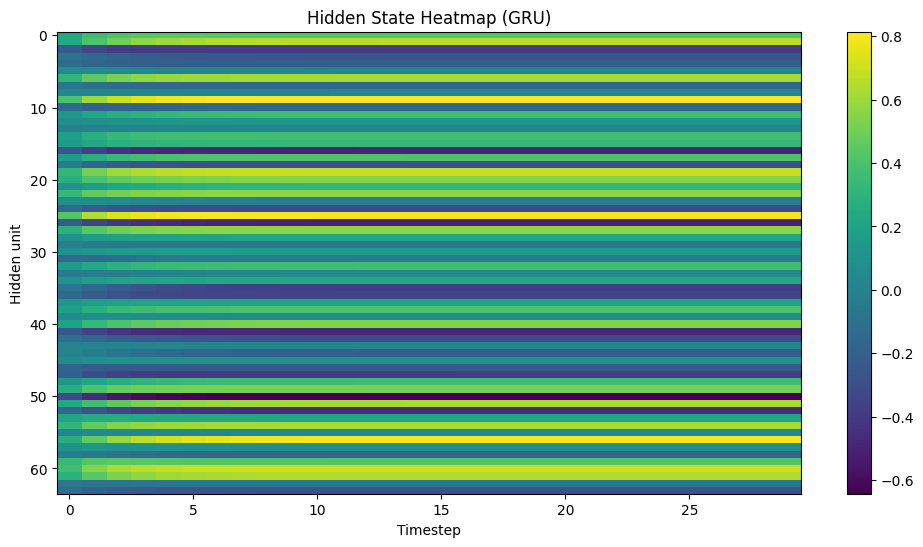

In [81]:
plot_hidden_states(gru_model, X_test[:1])